**Note.** *The following notebook contains code in addition to text and figures. By default, the code has been hidden. You can click the icon that looks like an eye in the toolbar above to show the code. Also note that the code should run when you first open the notebook, so it may take a few seconds to a minute before the figures appear. If the code doesn't run, you can click the calculator icon or go the cell menu and click "run all".*

# Amplitude modulation

This notebook shows how the model responds to an amplitude modulated signal. See [Basic Model](basic_model.ipynb) for details of the model.

Here, we assume that the firing rate variable $\rho$ is replaced by an amplitude modulated firing rate:

$$\rho(t)=\rho_{min}+(\rho_{max}-\rho_{min})\cdot (1-\cos(2\pi f_m t))/2$$

$\rho(t)$ varies with a modulation frequency of $f_m$ between a minimum of $\rho_{min}$ at the trough, to a maximum of $\rho_{max}$ at the peak. This models both the modulation depth of the signal and the rate-level curve. Note that compression and adaptation are not present in this model.

In [1]:
###### IMPORT AND UTILITY FUNCTIONS

%matplotlib inline
from brian2 import *
from model_explorer_jupyter import *
import joblib
import ipywidgets as ipw
from collections import OrderedDict
from scipy.ndimage.interpolation import zoom
from scipy.ndimage.filters import gaussian_filter
from matplotlib import cm
import matplotlib.patches as patches
import warnings
warnings.filterwarnings("ignore")
BrianLogger.log_level_error()

# Used for smoothing the plots, applies a Gaussian filter but works properly with nan values
def nan_gaussian_filter(x, sigma, num_passes):
    z = full_like(x, nan)
    for cursigma in linspace(sigma, 0, num_passes+1)[:-1]:
        y = gaussian_filter(x, cursigma, mode='nearest')
        z[isnan(z)] = y[isnan(z)]
    return z

progress_slider, update_progress = brian2_progress_reporter()

mem = joblib.Memory(cachedir="joblib", verbose=0)

In [2]:
%%html
<!-- hack to improve styling of ipywidgets sliders -->
<style type="text/css">
.widget-hbox .widget-label {
    min-width: 35ex;
    max-width: 35ex;
}
.widget-hslider {
    width: 100%;
}
.widget-hprogress {
    width: 100%;
}

</style>

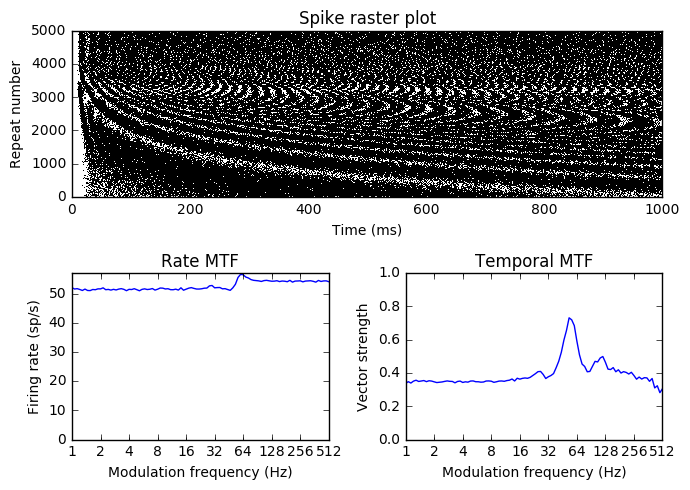

In [4]:
def mtf(fm_range_Hz, anf_rate_range_Hz, num_fm=10,
        mu_max=2.0, num_anf=50, tau_ms=6, inh=0.0,
        refractory_ms=0.6,
        repeats=50, duration_ms=1000,
        ):
    # Set parameters
    fm_min_Hz, fm_max_Hz = fm_range_Hz
    anf_rate_min_Hz, anf_rate_max_Hz = anf_rate_range_Hz
    duration = duration_ms*ms
    fm = fm_max_Hz*Hz
    tau = tau_ms*ms
    refractory = refractory_ms*ms
    anf_rate_min = anf_rate_min_Hz*Hz
    anf_rate_max = anf_rate_max_Hz*Hz
    weight = mu_max/(num_anf*tau*anf_rate_max*(1-inh))
    lfm_min = log2(fm_min_Hz)
    lfm_max = log2(fm_max_Hz)
    # Define and run the model
    eqs = '''
    fmi = int(i/repeats) : integer
    lfm = fmi/(num_fm-1.0)*(lfm_max-lfm_min)+lfm_min : 1
    fm = 2**lfm*Hz : Hz
    am = 0.5*(1-cos(2*pi*fm*t)) : 1
    anf_rate = (anf_rate_max-anf_rate_min)*am+anf_rate_min : Hz
    anf_rate_exc = anf_rate : Hz
    anf_rate_inh = anf_rate*inh : Hz
    mu_exc = weight*num_anf*tau*anf_rate_exc : 1
    mu_inh = weight*num_anf*tau*anf_rate_inh : 1
    sigma2_exc = weight*mu_exc : 1
    sigma2_inh = weight*mu_inh : 1
    mu = mu_exc-mu_inh : 1
    sigma = sqrt(sigma2_exc+sigma2_inh) : 1
    dv/dt = (mu-v)/tau+sigma*xi*tau**-0.5 : 1 (unless refractory)
    '''
    G = NeuronGroup(repeats*num_fm, eqs, threshold='v>1', reset='v=0',
                    refractory=refractory, method='heun')
    spikemon = SpikeMonitor(G)
    statemon = StateMonitor(G, 'v', record=[0])
    run(duration)
    # Compute rMTF and tMTF
    rMTF = zeros(num_fm)
    dMTF = zeros(num_fm)
    tMTF = zeros(num_fm, dtype=complex64)
    ntMTF = zeros(num_fm, dtype=int)
    fmi = arange(num_fm)
    lfm = fmi/(num_fm-1.0)*(lfm_max-lfm_min)+lfm_min
    fm = 2**lfm
    for i, train in enumerate(spikemon.spike_trains().values()):
        train.sort()
        f = fm[i/repeats]*Hz
        n = int(floor(duration*f))
        tmax = n/f
        train = train[train<tmax]
        rMTF[i/repeats] += len(train)
        dMTF[i/repeats] += float(tmax)
        tMTF[i/repeats] += sum(exp(1j*2*pi*fm[i/repeats]*train/second))
        ntMTF[i/repeats] += len(train)
    I = ntMTF>10 # only plot tMTF if we have >10 spikes
    tMTF = abs(tMTF)/ntMTF # rMTF is the number of spikes at this point
    rMTF /= dMTF
    # Plot results
    figure(figsize=(7, 5))
    subplot(211)
    plot(spikemon.t/ms, spikemon.i, ',k')
    xlabel('Time (ms)')
    ylabel('Repeat number')
    title('Spike raster plot')
    xlim(0, duration/ms)
    ylim(0, repeats*num_fm)
    
    subplot(223)
    semilogx(fm, rMTF, basex=2)
    xlabel('Modulation frequency (Hz)')
    ylabel('Firing rate (sp/s)')
    xlim(fm_min_Hz, fm_max_Hz)
    xt, _ = xticks()
    xticks(xt, map(str, map(int, xt)))
    xlim(fm_min_Hz, fm_max_Hz)
    ylim(ymin=0)
    title('Rate MTF')
    
    subplot(224)
    semilogx(fm[I], tMTF[I], basex=2)
    xlabel('Modulation frequency (Hz)')
    ylabel('Vector strength')
    xlim(fm_min_Hz, fm_max_Hz)
    xt, _ = xticks()
    xticks(xt, map(str, map(int, xt)))
    xlim(fm_min_Hz, fm_max_Hz)
    ylim(0, 1)
    title('Temporal MTF')
    
    tight_layout()

ipw.interact(mtf,
             tau_ms=ipw.FloatSlider(
                 min=0.1, max=20.0, step=0.1, value=10.0,
                 continuous_update=False,
                 description=r"Membrane time constant $\tau$ (ms)"),
             refractory_ms=ipw.FloatSlider(
                 min=0, max=5, step=0.05, value=1,
                 continuous_update=False,
                 description=r"Refractory period $t_\mathrm{ref}$ (ms)"),
             mu_max=ipw.FloatSlider(
                 min=0, max=5, step=0.05, value=1.5,
                 continuous_update=False,
                 description=r"Maximum mean current $\mu$"),
             fm_range_Hz=ipw.IntRangeSlider(
                 min=1, max=512, step=1, value=(1, 512),
                 continuous_update=False,
                 description=r"Modulation frequency range (Hz)"),
             num_fm=ipw.IntSlider(
                 min=5, max=250, step=5, value=10,
                 continuous_update=False,
                 description=r"Modulation frequency number of points"),
             num_anf=ipw.IntSlider(
                 min=1, max=100, step=1, value=50,
                 continuous_update=False,
                 description=r"Number of input synapses"),
             inh=ipw.FloatSlider(
                 min=0, max=1, step=0.05, value=0,
                 continuous_update=False,
                 description=r"Fraction of inhibition $\alpha$"),
             anf_rate_range_Hz=ipw.IntRangeSlider(
                 min=10, max=500, step=10, value=(150, 250),
                 continuous_update=False,
                 description=r"ANF firing rate at modulation minimum/maximum (sp/s)"),
             duration_ms=ipw.IntSlider(
                 min=100, max=10000, step=100, value=1000,
                 continuous_update=False,
                 description=r"Duration (ms)"),
             repeats=ipw.IntSlider(
                 min=5, max=500, step=5, value=50,
                 continuous_update=False,
                 description=r"Repeats"),
             );